# (D+1)-Regular q-Uniform hypergraphs

## we want to have approximately (D+1) hyperedges for each vertex and q vertices per hyperedge

In [1]:
import numpy as np
from copy import copy
import timeit as timeit
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import csv

n=40
q=4
d=10


### Implementing configuration model

In [2]:
def gen_graph(v,p,k): #vertex, no. int spin, degree (k)
    dic = {}
    for i in range(n): #count how many more hyperedges are needed for each vertex
        dic[f"{i}"]=d
    edges = []
    for i in range(int(v/2)): #for each vertex
        counter=0
        while dic[f"{i}"]>0: #while current vertex has degree<d
            edge = {i,}     #create hyperedge with i 
            if counter >100:#if fail to get hyperedge
                break
            while len(edge)<p:  #while hyperedge has less than q vertices
                x=np.random.randint(i+1,high=n)   #get random vertex from i+1 to n
                if dic[f"{x}"]>0:  #check if vertex still is under degree 2
                    if x not in edge:
                        edge.add(x)
                        dic[f"{x}"]-=1
                counter +=1
                if counter >100:#if fail to get hyperedge after 1000 iteration, skip
                    for j in edge:#re-add number back to dictionary
                        if j != i:
                            dic[f"{j}"]+=1
                    break
            if len(edge)== p:#if hyperedge is valid
                edges+=[edge]
                dic[f"{i}"]-=1 #minus from current vertex
                counter=0
            if counter >100:#if fail to get hyperedge
                break
    return edges,dic
def leftovers(v,dic): #find vertices that have degree < d
    left =[]
    for i in range(v): #for each vertex
        if dic[f"{i}"]>0:
            left+=[i,]
    return left

def fingraph(V,HE,p,k,dic): #input vertices and current set of hyperedges, p int spin, and degree k
    #finishes an incomplete regular graph if it's possible
    lvert=leftovers(V,dic)  #vertices that are leftover (i.e. less than degree k)
    n = len(HE)       #number of hyperedges left
    for i in range(n):
        counter=0
        if lvert==[]:   #if all vertices have degree k
            break
        x=np.random.choice(lvert)  #choose a random vertex in list
        edge ={x}
        dic[f"{x}"]-=1
        if dic[f"{x}"]==0:   #if after adding hyperedge, this vertex has degree k
            lvert.remove(x)
        if len(lvert)<(p-1):     #if list of vertex is less than enough to form hyperedge
            break
        while len(edge)<p:      #while hyperedge does not have p vertices
            x=np.random.choice(lvert)   #choose random vertex
            counter +=1
            if x not in edge:     #if vertex not already in edge
                edge.add(x)
                dic[f"{x}"]-=1
                if dic[f"{x}"]==0:
                    lvert.remove(x)
            if counter >100:
                break
        HE+=[edge]
    return HE

def truegraph(v,p,k):#generate the random regular graph using above codes
    theory = v*k/p
    temp=[]
    while len(temp)<int(theory):
        temp,dic=gen_graph(v,p,k)
        temp=fingraph(v,temp,p,k,dic)
    return temp

def lstedges(HE): #convert set of edges into a sorted list via highest vertex number
    lst=[]
    for edge in HE:
        temp = list(edge)
        temp.sort()
        lst += [temp]
    lst= sorted(lst,key=lambda x: x[-1])
    return lst

edges = lstedges(truegraph(n,q,d))
print("# edges (th):", n*d/q)            
print("# edges (ac):", len(edges))


# edges (th): 100.0
# edges (ac): 100


## Implementing the Hamiltonian/ cost function

In [3]:
def coup(HE): #list of hyperedges
    temp = []
    binary = [-1,1]
    for i in range(len(HE)):
        temp+=[np.random.choice(binary)]
    return temp

Js=coup(edges) 

def cost(V,HE,J): #input bitstring, hyperedges, couplings
    count = 0
    for i in range(len(HE)):
        temp = J[i]
        edge = HE[i]
        for z in edge:
            temp*= V[z]
        temp+=1
        count+= 0.5*(temp)
    return count
        

## Define branch and bound algorithm to find e-optimal solutions

In [4]:
def branch(bit):
    return np.append(bit,[1]),np.append(bit,[-1])

def qbound(bit,HE,J,sat):
    global n
    x = len(bit)
    value = sat
    for i in range(len(HE)):
        temp = J[i]
        edge = HE[i]
        if edge[-1]>=x:
            break
        elif edge[-1]==(x-1):
            for z in edge:
                temp*= bit[z]
            temp += 1
            value +=0.5*(temp)
            value -=1
    return value

def Dist(v):
    n=len(v)
    temp=[1 for i in range(n)]
    return((np.dot(temp,v)/n +1)/2)

def qspin_opt(bit,HE,J,sat,threshold):
    global xdata,ydata,strings,n
    if qbound(bit,HE,J,sat)/len(HE)>threshold:
        if len(bit)== n:
            strings +=[bit]
            xdata+=[Dist(bit)]
            ydata+=[qbound(bit,HE,J,sat)/len(HE)]
        else:
            bit1,bit2 = branch(bit)
            qspin_opt(bit1,HE,J,qbound(bit,HE,J,sat),threshold)
            qspin_opt(bit2,HE,J,qbound(bit,HE,J,sat),threshold)


In [ ]:
xdata,ydata,strings = [],[],[]

start = timeit.default_timer()
qspin_opt([],edges,Js,n*d/q,0.8)
print("The difference of time is :", 
               (timeit.default_timer() - start)/(60*60*24),"days")


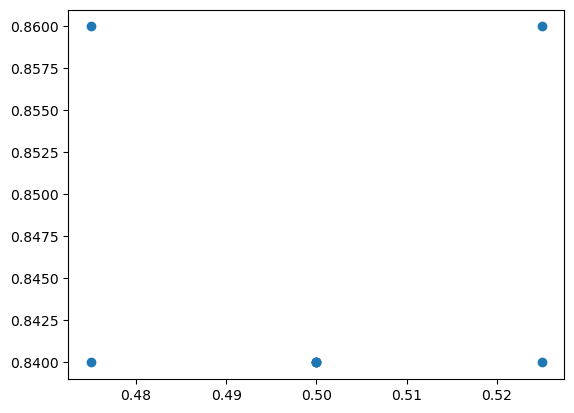

In [6]:
plt.scatter(xdata,ydata)

In [7]:
# f = open('n36d10.csv','w')
# writer = csv.writer(f)
# header = ['bit','overlap', 'Cost']
# writer.writerow(header)
# for i in range(len(xdata)):
#     writer.writerow([strings[i],xdata[i],ydata[i]])
# f.close()


# f = open('H_n30_d6.csv','w')
# writer = csv.writer(f)
# header = ['HE','J']
# writer.writerow(header)
# for i in range(len(edges)):
#     writer.writerow([edges[i],Js[i]])
# f.close()

# plt.scatter(xdata,ydata)

## Define function to get only e-optimal solution

In [19]:
def eopt(databit,datay,value):
    temp = []
    x=max(datay)
    for i in range(len(datay)):
        if datay[i]>=value*x:
            temp+=[databit[i]]
    return temp

In [25]:
A=eopt(strings,ydata,0.9)
print(len(A))

8


## define function to calculate overlap over all e-optimal solution

In [26]:
def Ham(s,t):
    n=len(s)
    return(1-np.abs(np.dot(s,t)/n))

def OGP(data):
    C=set()
    for i in range(len(data)):
        for j in range(i+1,len(data)):
            C.add(Ham(data[i],data[j]))
    C=list(C)
    C+=[0]
    C.sort()
    return C


In [27]:
C=OGP(A)
D=[]
for i in C:
    D+=[0]
    
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=C, y=D, mode='markers', marker_size=18,
))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, 
                 zeroline=True, zerolinecolor='black', zerolinewidth=3,
                 showticklabels=False)
fig.update_layout(height=200, plot_bgcolor='white')

# Numerical results for SK Model and OGP

## repeat the same time but for the SK model

In [13]:
def Hclassic(k):
    temp =np.zeros( (k, k) ) #create (n,n) matrix
    for i in range(0,k-1):
        for j in range(i+1,k):
            temp[i][j]=np.random.normal(0, 1)/np.sqrt(n) #insert random coupling strength
    return temp


def costhsk(V,H): #input bitstring, Hamiltonian
    return np.matmul(np.matmul(V,H),V)

def branch(bit):
    return np.append(bit,[1]),np.append(bit,[-1])

def boundhsk(bit,H):
    x = len(bit)
    temp = bit.copy()
    lst = [0 for i in range(x)]
    if x == len(H):
        return costhsk(bit,H)
    while x<len(H):
        temp = np.append(temp,[0])
        lst=np.append(lst,[1])
        x+= 1
    value = costhsk(temp,H)
    value += np.matmul(np.abs(np.matmul(temp,H)),lst)
    value += np.matmul(np.abs(np.matmul(lst,np.abs(H))),lst)
    return value

def getstrings(bit,H,threshold):
    global tempx,tempy,lst
    if (boundhsk(bit,H)/len(H))>threshold:
        if len(bit)==len(H):
            if (costhsk(bit,H)/len(H))> threshold:
                lst +=[bit]
                tempx+=[Dist(bit)]
                tempy+=[costhsk(bit,H)/len(H)]
        else:
            bit1,bit2=branch(bit)
            getstrings(bit1,H,threshold)
            getstrings(bit2,H,threshold)
    return("done")
    

In [14]:
m=45
HSK = Hclassic(m)
boundhsk([1],HSK)/m

In [15]:
tempx=[]
tempy=[]
lst= []
start = timeit.default_timer()
getstrings([1],HSK,0.7)
print("The difference of time is :", 
                (timeit.default_timer() - start)/(60),"min")

In [16]:
plt.scatter(tempx,tempy)

In [17]:
len(tempy)

In [18]:
A=eopt(lst,tempy,0.97)
C=OGP(A)
D=[]
for i in C:
    D+=[0]
    
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=C, y=D, mode='markers', marker_size=18,
))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, 
                 zeroline=True, zerolinecolor='black', zerolinewidth=3,
                 showticklabels=False)
fig.update_layout(height=200, plot_bgcolor='white')